In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from numpy import percentile
!pip install pyod
# Import all models
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

import pandas as pd
from scipy import linalg
from scipy.stats import skew, kurtosis
from sklearn.metrics import pairwise_distances, f1_score
!pip install tensorly
from tensorly.decomposition.robust_decomposition import robust_pca

from scipy.stats import skewnorm

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

In [2]:
def fit_m_rpca(data, m_reg_J=1):
    """
    Robust PCA based estimation of mean, covariance, skewness and kurtosis.
    
    :param data: MxN matrix with M observations and N features, where M>N 
    :param m_reg_J: regularization. Default value is 1
    :return: 
        L: array-like, shape (m_obserations, n_features,)
            Robust data
        
        rob_mean:
        rob_cov:
        rob_dist:
        rob_precision:
        rob_skew:
        rob_skew_dist:
        rob_kurt:
        rob_kurt_dist:
    """

    L, S = robust_pca(data, reg_J=m_reg_J)
    rob_mean = L.mean(axis=0)
    rob_cov = pd.DataFrame(L).cov()
    rob_precision = linalg.pinvh(rob_cov)
    rob_dist = (np.dot(L, rob_precision) * L).sum(axis=1)
    rob_skew = skew(L, axis=0, bias=True)
    rob_skew_dist = (np.dot(L - rob_skew, rob_precision) * (L - rob_skew)).sum(axis=1)
    rob_kurt = kurtosis(L, axis=0, fisher=True, bias=True)
    rob_kurt_dist = (np.dot(L - rob_kurt, rob_precision) * (L - rob_kurt)).sum(axis=1)

    return L, rob_mean, rob_cov, rob_dist, rob_precision, rob_skew, rob_skew_dist, rob_kurt, rob_kurt_dist


def cv_location_contamination(cv_df, cv_labels, location, precision):
    """

    :param cv_df: cross-validation data frame
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param location: mean vector
    :param precision: inverse of covariance matrix
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    contamination = round(0.00, 2)
    contamination_prediction_list = []
    labels = np.array(cv_labels)

    for i in range(40):
        contamination += 0.01
        contamination = round(contamination, 2)
        pred_label = predict_by_location_contamination(cv_df, location, precision, contamination)
        contamination_prediction_list.append((contamination, f1_score(labels, pred_label, average="binary")))

    contamination_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    contamination_best_f1 = contamination_prediction_list[0][0]

    return contamination_best_f1


def cv_location_threshold(cv_df, cv_labels, location, precision, dist):
    """

    :param cv_df: cross-validation data frame
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param location:
    :param precision:
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    threshold_prediction_list = []
    labels = np.array(cv_labels)
    min_dist = min(dist)
    max_dist = max(dist)

    for m_threshold in np.linspace(min_dist, max_dist, 40):
        pred_label = predict_by_location_threshold(cv_df, location, precision, m_threshold)
        threshold_prediction_list.append((m_threshold, f1_score(labels, pred_label, average="binary")))

    threshold_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_threshold = threshold_prediction_list[0][0]

    return best_threshold


def cv_skewness_contamination(cv_df, cv_labels, skewness, precision):
    """

    :param cv_df: cross-validation data frame
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param skewness:
    :param precision:
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    contamination = round(0.00, 2)
    contamination_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    for i in range(40):
        contamination += 0.01
        contamination = round(contamination, 2)
        pred_label = predict_by_skewness_contamination(cv_df, precision, skewness, contamination)
        contamination_prediction_list.append((contamination, f1_score(actual_anomalies, pred_label, average="binary")))

    contamination_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_contamination = contamination_prediction_list[0][0]

    return best_contamination


def cv_skewness_threshold(cv_df, cv_labels, skewness, precision, skew_dist):
    """

    :param cv_df:
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param skewness:
    :param precision:
    :param skew_dist:
    :return:
    """

    threshold_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    min_dist = min(skew_dist)
    max_dist = max(skew_dist)

    for m_threshold in np.linspace(min_dist, max_dist, 40):
        pred_label = predict_by_skewness_threshold(cv_df, precision, skewness, m_threshold)
        threshold_prediction_list.append((m_threshold, f1_score(actual_anomalies, pred_label, average="binary")))

    threshold_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_threshold = threshold_prediction_list[0][0]

    return best_threshold


def cv_kurtosis_contamination(cv_df, cv_labels, m_kurtosis, precision):
    """

    :param df: cross-validation data frame
    :param location:
    :param precision:
    :return: For all tested contamination rates, returns the rate in which the best F1-score were achieved.
    """

    contamination = round(0.00, 2)
    contamination_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    for i in range(40):
        contamination += 0.01
        contamination = round(contamination, 2)
        pred_label = predict_by_kurtosis_contamination(cv_df, precision, m_kurtosis, contamination)
        contamination_prediction_list.append((contamination, f1_score(actual_anomalies, pred_label, average="binary")))

    contamination_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_contamination = contamination_prediction_list[0][0]

    return best_contamination


def cv_kurtosis_threshold(cv_df, cv_labels, kurtosis, precision, kurt_dist):
    """

    :param cv_df:
    :param cv_labels: labels to evaluate prediction performance by contamination
    :param kurtosis:
    :param precision:
    :param kurt_dist:
    :return:
    """

    threshold_prediction_list = []
    actual_anomalies = np.array(cv_labels)
    min_dist = min(kurt_dist)
    max_dist = max(kurt_dist)

    for m_threshold in np.linspace(min_dist, max_dist, 40):
        pred_label = predict_by_kurtosis_threshold(cv_df, precision, kurtosis, m_threshold)
        threshold_prediction_list.append((m_threshold, f1_score(actual_anomalies, pred_label, average="binary")))

    threshold_prediction_list.sort(key=lambda tup: tup[1], reverse=True)
    best_threshold = threshold_prediction_list[0][0]

    return best_threshold


def md_rpca_prediction(test_df, location, precision, contamination):
    """

    :param test_df:
    :param location:
    :param precision:
    :param contamination:
    :return:
    """

    pred_label = np.full(test_df.shape[0], 0, dtype=int)
    if contamination is not None:
        # malhalanobis distance
        mahal_dist = pairwise_distances(test_df, location[np.newaxis, :], metric='mahalanobis', VI=precision)
        mahal_dist = np.reshape(mahal_dist, (len(test_df),)) ** 2  #MD squared
        # detect outliers
        contamination_threshold = np.percentile(mahal_dist,  100. * (1. - contamination))
        pred_label[mahal_dist > contamination_threshold] = 1
    else:
        raise NotImplementedError("You must provide a contamination rate.")

    return pred_label, mahal_dist


def predict_by_location_centered_contamination(X, location, precision, contamination):
    """

    :param X:
    :param location:
    :param precision:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)
    if contamination is not None:
        # malhalanobis distance
        X = X - location
        mahal_dist = pairwise_distances(X, location[np.newaxis, :], metric='mahalanobis', VI=precision)
        mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  #MD squared
        # detect outliers
        contamination_threshold = np.percentile(mahal_dist,  100. * (1. - contamination))
        pred_label[mahal_dist > contamination_threshold] = 1
    else:
        raise NotImplementedError("You must provide a contamination rate.")

    return pred_label


def predict_by_location_threshold(X, location, precision, threshold):
    """

    :param X:
    :param location:
    :param precision:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, location[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  #MD squared
    # detect outliers
    pred_label[mahal_dist > threshold] = 1

    return pred_label


def sd_rpca_prediction(X, skewness, precision, contamination):
    """

    :param X:
    :param precision:
    :param skewness:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_skew_dist, 100. * contamination)
    pred_label[pred_skew_dist <= contamination_threshold] = 1

    return pred_label, pred_skew_dist


def predict_by_skewness_centered_contamination(X, precision, skewness, contamination):
    """

    :param X:
    :param precision:
    :param skewness:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # skewness of the data
    X_skew = X - skew(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_skew, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_skew),)) ** 2 #MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_skew_dist, 100. * contamination)
    pred_label[pred_skew_dist <= contamination_threshold] = 1

    return pred_label


def predict_by_skewness_threshold(X, precision, skewness, threshold):
    """

    :param X:
    :param precision:
    :param skewness:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    pred_label[pred_skew_dist <= threshold] = 1

    return pred_label


def predict_by_skewness_centered_threshold(X, precision, skewness, threshold):
    """

    :param X:
    :param precision:
    :param skewness:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # skewness of the data
    X_skew = X - skew(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_skew, skewness[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_skew),)) ** 2  # MD squared
    pred_skew_dist = -mahal_dist

    # detect outliers
    pred_label[pred_skew_dist <= threshold] = 1

    return pred_label


def kd_rpca_prediction(X, m_kurtosis, precision, contamination):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_kurt_dist, 100. * contamination)
    pred_label[pred_kurt_dist <= contamination_threshold] = 1

    return pred_label, pred_kurt_dist


def predict_by_kurtosis_centered_contamination(X, precision, m_kurtosis, contamination):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param contamination:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # m_kurtosis	 of the data
    X_kurt = X - kurtosis(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_kurt, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_kurt),)) ** 2 #MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    contamination_threshold = np.percentile(pred_kurt_dist, 100. * contamination)
    pred_label[pred_kurt_dist <= contamination_threshold] = 1

    return pred_label


def predict_by_kurtosis_threshold(X, precision, m_kurtosis, threshold):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    pred_label[pred_kurt_dist <= threshold] = 1

    return pred_label


def predict_by_kurtosis_centered_threshold(X, precision, m_kurtosis, threshold):
    """

    :param X:
    :param precision:
    :param m_kurtosis	:
    :param threshold:
    :return:
    """

    pred_label = np.full(X.shape[0], 0, dtype=int)

    # m_kurtosis	 of the data
    X_kurt = X - kurtosis(X, axis=0, bias=True)

    # malhalanobis distance
    mahal_dist = pairwise_distances(X_kurt, m_kurtosis[np.newaxis, :], metric='mahalanobis', VI=precision)
    mahal_dist = np.reshape(mahal_dist, (len(X_kurt),)) ** 2  # MD squared
    pred_kurt_dist = -mahal_dist

    # detect outliers
    pred_label[pred_kurt_dist <= threshold] = 1

    return pred_label

In [3]:
# Define the number of inliers and outliers
n_samples = 2400
#outliers_fraction = 0.33
#outliers_fraction = 0.25
outliers_fraction = 0.10
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(n_samples - n_inliers)

# result path
result_path = 'output/synthetic/'

# Initialize the data
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1 #put outliers into the end

# print the data shapes
print('n_samples:', n_samples)
print('n_inliers:', n_inliers)
print('n_outliers:', n_outliers)
print('ground_truth:', ground_truth.shape)

n_samples: 2400
n_inliers: 2160
n_outliers: 240
ground_truth: (2400,)


In [4]:
# Gaussian
np.random.seed(11)
X1 = 0.3 * np.random.randn(n_inliers, 2)
X2 = 0.3 * np.random.randn(n_inliers, 2) 
Xgaussian = np.r_[X1, X2]
Xgaussian_t = Xgaussian[:n_inliers]
print('Xgaussian_t:', Xgaussian_t.shape)
Xgaussian = Xgaussian[n_inliers:]
print('Xgaussian:', Xgaussian.shape)

Xgaussian_t: (2160, 2)
Xgaussian: (2160, 2)


In [5]:
# Append uniform outliers
Cuniform = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
Xgu = np.r_[Xgaussian,Cuniform]
print('Xgu:', Xgu.shape)

Xgu: (2400, 2)


In [6]:
# Contaminated Gaussian
Ctuniform = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
Xgaussian_tc = np.r_[Xgaussian_t, Ctuniform]
print('Xgaussian_tc:', Xgaussian_tc.shape)

Xgaussian_tc: (2400, 2)


In [7]:
# # Pareto distribution
# np.random.seed(42)
# a = 3.  # shape
# m = 1.  # mode

# p1 = (np.random.pareto(a, n_inliers) + 1) * m
# p2 = (np.random.pareto(a, n_inliers) + 1) * m
# Xpareto = np.vstack((p1,p2)).transpose()
# print('Xpareto:', Xpareto.shape)

# p1 = (np.random.pareto(a, n_inliers) + 1) * m
# p2 = (np.random.pareto(a, n_inliers) + 1) * m
# Xpareto_t = np.vstack((p1,p2)).transpose()
# print('Xpareto_t:', Xpareto_t.shape)

# # Add outliers
# Cgaussian = 0.1 * np.random.randn(n_outliers, 2)
# print('Cgaussian:', Cgaussian.shape)
# Xpg = np.r_[Xpareto, Cgaussian]
# print('Xpg:', Xpg.shape)

# np.random.seed(42)
# Ct = 0.1 * np.random.randn(n_outliers, 2)
# Xpareto_tc = np.r_[Xpareto_t, Ct]

# Xgaussian_t = Xpareto_t
# Xgaussian_tc = Xpareto_tc
# Xgu = Xpg

In [8]:
random_state = np.random.RandomState(42)

# Define nine outlier detection tools to be compared
classifiers = {
    'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(contamination=outliers_fraction, random_state=random_state),
}

for i, (clf_name, clf) in enumerate(classifiers.items()):    
    # fit the data and tag outliers
    clf.fit(Xgu)
    scores_pred = clf.decision_function(Xgu) * -1
    y_pred = clf.predict(Xgu)
    threshold = percentile(scores_pred, 100 * outliers_fraction)    
    f1 = f1_score(ground_truth, y_pred, average="binary")
    print(i + 1, 'fitting', clf_name, f1)

1 fitting Isolation Forest 0.9708333333333333
2 fitting K Nearest Neighbors (KNN) 0.9727463312368972
3 fitting Local Outlier Factor (LOF) 0.2923728813559322
4 fitting Minimum Covariance Determinant (MCD) 0.975
5 fitting One-class SVM (OCSVM) 0.975
6 fitting Principal Component Analysis (PCA) 0.9291666666666667


In [9]:
# Train
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_m_rpca(Xgaussian_t)
# Testing md-rpca
md_pred_label, md_pred_dist = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('ss_md_rpca - F1: %f' % (md_f1))
# Testing sd-rpca
sd_pred_label, sd_pred_dist = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('ss_sd_rpca - F1: %f' % (sd_f1))
# Testing kd-rpca
kd_pred_label, kd_pred_dist = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('ss_kd_rpca - F1: %f' % (kd_f1))

# Train
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_m_rpca(Xgaussian_tc)
# Testing md-rpca
md_pred_label, md_pred_dist = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('css_md_rpca - F1: %f' % (md_f1))
# Testing sd-rpca
sd_pred_label, sd_pred_dist = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('css_sd_rpca - F1: %f' % (sd_f1))
# Testing kd-rpca
kd_pred_label, kd_pred_dist = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('css_kd_rpca - F1: %f' % (kd_f1))

# Train
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_m_rpca(Xgu)
# Testing md-rpca
md_pred_label, md_pred_dist = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('u_md_rpca - F1: %f' % (md_f1))
# Testing sd-rpca
sd_pred_label, sd_pred_dist = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('u_sd_rpca - F1: %f' % (sd_f1))
# Testing kd-rpca
kd_pred_label, kd_pred_dist = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('u_kd_rpca - F1: %f' % (kd_f1))

ss_md_rpca - F1: 0.975000
ss_sd_rpca - F1: 0.975000
ss_kd_rpca - F1: 0.970833
css_md_rpca - F1: 0.975000
css_sd_rpca - F1: 0.962500
css_kd_rpca - F1: 0.487500
u_md_rpca - F1: 0.975000
u_sd_rpca - F1: 0.970833
u_kd_rpca - F1: 0.504167


In [10]:
from tensorly import fold, unfold

def fit_t_m_rpca(tensor, m_reg_J=1):

    L, S = robust_pca(tensor, reg_J=m_reg_J)
    L = unfold(L.T, 1)
    L = L.T

    rob_mean = L.mean(axis=0)
    rob_cov = pd.DataFrame(L).cov()
    rob_precision = linalg.pinvh(rob_cov)
    rob_dist = (np.dot(L, rob_precision) * L).sum(axis=1)

    rob_skew = skew(L, axis=0, bias=True)
    rob_skew_dist = (np.dot(L - rob_skew, rob_precision) * (L - rob_skew)).sum(axis=1)

    rob_kurt = kurtosis(L, axis=0, fisher=True, bias=True)
    rob_kurt_dist = (np.dot(L - rob_kurt, rob_precision) * (L - rob_kurt)).sum(axis=1)

    return L, rob_mean, rob_cov, rob_dist, rob_precision, rob_skew, rob_skew_dist, rob_kurt, rob_kurt_dist

import warnings
import types
import sys
import numpy.core.numeric as _nx
from numpy.core import linspace
from numpy.core.numeric import ones, zeros, arange, concatenate, array, \
        asarray, asanyarray, empty, empty_like, ndarray, around
from numpy.core.numeric import ScalarType, dot, where, newaxis, intp, \
        integer, isscalar
from numpy.core.umath import pi, multiply, add, arctan2,  \
        frompyfunc, isnan, cos, less_equal, sqrt, sin, mod, exp, log10
from numpy.core.fromnumeric import ravel, nonzero, choose, sort, partition, mean
from numpy.core.numerictypes import typecodes, number
from numpy.core import atleast_1d, atleast_2d
from numpy.lib.twodim_base import diag
import numpy as np
import collections
from numpy.compat import long

def npcov(m, y=None, rowvar=1, bias=0, ddof=None):
    """
    Estimate a covariance matrix, given data.
    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, :math:`X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element :math:`C_{ij}` is the covariance of
    :math:`x_i` and :math:`x_j`. The element :math:`C_{ii}` is the variance
    of :math:`x_i`.
    Parameters
    ----------
    m : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `m` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and observations. `y` has the same
        form as that of `m`.
    rowvar : int, optional
        If `rowvar` is non-zero (default), then each row represents a
        variable, with observations in the columns. Otherwise, the relationship
        is transposed: each column represents a variable, while the rows
        contain observations.
    bias : int, optional
        Default normalization is by ``(N - 1)``, where ``N`` is the number of
        observations given (unbiased estimate). If `bias` is 1, then
        normalization is by ``N``. These values can be overridden by using
        the keyword ``ddof`` in numpy versions >= 1.5.
    ddof : int, optional
        .. versionadded:: 1.5
        If not ``None`` normalization is by ``(N - ddof)``, where ``N`` is
        the number of observations; this overrides the value implied by
        ``bias``. The default value is ``None``.
    Returns
    -------
    out : ndarray
        The covariance matrix of the variables.
    See Also
    --------
    corrcoef : Normalized covariance matrix
    Examples
    --------
    Consider two variables, :math:`x_0` and :math:`x_1`, which
    correlate perfectly, but in opposite directions:
    >>> x = np.array([[0, 2], [1, 1], [2, 0]]).T
    >>> x
    array([[0, 1, 2],
           [2, 1, 0]])
    Note how :math:`x_0` increases while :math:`x_1` decreases. The covariance
    matrix shows this clearly:
    >>> np.cov(x)
    array([[ 1., -1.],
           [-1.,  1.]])
    Note that element :math:`C_{0,1}`, which shows the correlation between
    :math:`x_0` and :math:`x_1`, is negative.
    Further, note how `x` and `y` are combined:
    >>> x = [-2.1, -1,  4.3]
    >>> y = [3,  1.1,  0.12]
    >>> X = np.vstack((x,y))
    >>> print np.cov(X)
    [[ 11.71        -4.286     ]
     [ -4.286        2.14413333]]
    >>> print np.cov(x, y)
    [[ 11.71        -4.286     ]
     [ -4.286        2.14413333]]
    >>> print np.cov(x)
    11.71
    """
    # Check inputs
    if ddof is not None and ddof != int(ddof):
        raise ValueError("ddof must be integer")

    X = np.array(m, ndmin=2, dtype=float)

    if X.size == 0:
        # handle empty arrays
        return np.array(m)

    if X.shape[0] == 1:
        rowvar = 1

    if rowvar:
        axis = 0
        tup = (slice(None), newaxis)
    else:
        axis = 1
        tup = (newaxis, slice(None))

    if y is not None:
        y = array(y, copy=False, ndmin=2, dtype=float)
        X = concatenate((X, y), axis)

    X -= X.mean(axis=1-axis)[tup]

    if rowvar:
        N = X.shape[1]
    else:
        N = X.shape[0]

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    fact = float(N - ddof)

    if not rowvar:
        return (dot(X.T, X.conj()) / fact).squeeze()
    else:
        return (dot(X, X.T.conj()) / fact).squeeze()

In [11]:
from tensorly import fold

t_Xgaussian_t = fold(Xgaussian_t, 2, (54,2,40))
print('Xgaussian_t:', Xgaussian_t.shape, t_Xgaussian_t.shape)

t_Xgaussian_tc = fold(Xgaussian_tc, 2, (60,2,40))
print('t_Xgaussian_tc:', Xgaussian_tc.shape, t_Xgaussian_tc.shape)

t_Xgu = fold(Xgu, 2, (60,2,40))
print('t_Xgu:', Xgu.shape, t_Xgu.shape)

Xgaussian_t: (2160, 2) (54, 2, 40)
t_Xgaussian_tc: (2400, 2) (60, 2, 40)
t_Xgu: (2400, 2) (60, 2, 40)


In [12]:
# Train
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_t_m_rpca(t_Xgaussian_t, m_reg_J=0.1)
# Testing md-rpca
md_pred_label, md_pred_dist = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('ss_md_rpca - F1: %f' % (md_f1))
# Testing sd-rpca
sd_pred_label, sd_pred_dist = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('ss_sd_rpca - F1: %f' % (sd_f1))
# Testing kd-rpca
kd_pred_label, kd_pred_dist = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('ss_kd_rpca - F1: %f' % (kd_f1))

# Train
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_t_m_rpca(t_Xgaussian_tc, m_reg_J=0.01)
# Testing md-rpca
md_pred_label, md_pred_dist = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('css_md_rpca - F1: %f' % (md_f1))
# Testing sd-rpca
sd_pred_label, sd_pred_dist = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('css_sd_rpca - F1: %f' % (sd_f1))
# Testing kd-rpca
kd_pred_label, kd_pred_dist = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('css_kd_rpca - F1: %f' % (kd_f1))

# Train
r_L, r_mu, r_cov, r_dist, r_precision, r_skew, _, r_kurt, _ = fit_t_m_rpca(t_Xgu, m_reg_J=0.5)
# Testing md-rpca
md_pred_label, md_pred_dist = md_rpca_prediction(Xgu, r_mu, r_precision, outliers_fraction)
md_f1 = f1_score(ground_truth, md_pred_label, average="binary")
print('u_md_rpca - F1: %f' % (md_f1))
# Testing sd-rpca
sd_pred_label, sd_pred_dist = sd_rpca_prediction(Xgu, r_skew, r_precision, outliers_fraction)
sd_f1 = f1_score(ground_truth, sd_pred_label, average="binary")
print('u_sd_rpca - F1: %f' % (sd_f1))
# Testing kd-rpca
kd_pred_label, kd_pred_dist = kd_rpca_prediction(Xgu, r_kurt, r_precision, outliers_fraction)
kd_f1 = f1_score(ground_truth, kd_pred_label, average="binary")
print('u_kd_rpca - F1: %f' % (kd_f1))

ss_md_rpca - F1: 0.975000
ss_sd_rpca - F1: 0.975000
ss_kd_rpca - F1: 0.970833
css_md_rpca - F1: 0.975000
css_sd_rpca - F1: 0.962500
css_kd_rpca - F1: 0.487500
u_md_rpca - F1: 0.975000
u_sd_rpca - F1: 0.970833
u_kd_rpca - F1: 0.504167


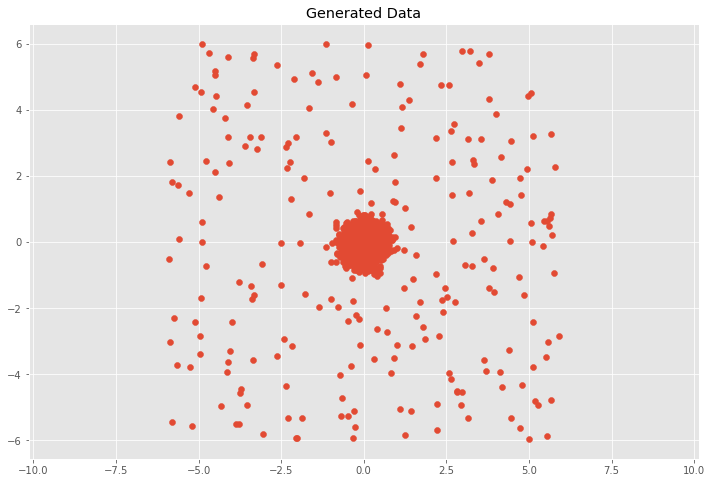

In [13]:
X = Xgu
# X = Xgaussian_t
# X = Xgaussian_tc
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated Data')
plt.axis('equal');

In [14]:
# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])

In [15]:
print('Xgu:', Xgu.shape)
print('t_Xgu:', t_Xgu.shape)
print('1-t_Xgu:', unfold(t_Xgu, 0).shape)
print('2-t_Xgu:', unfold(t_Xgu, 1).shape)
print('3-t_Xgu:', unfold(t_Xgu, 2).shape)

Xgu: (2400, 2)
t_Xgu: (60, 2, 40)
1-t_Xgu: (60, 80)
2-t_Xgu: (2, 2400)
3-t_Xgu: (40, 120)


In [16]:
cov_mat(Xgu.T)

array([[ 1.29461387, -0.07977427],
       [-0.07977427,  1.28388689]])

In [17]:
npcov(Xgu.T)

array([[ 1.29461387, -0.07977427],
       [-0.07977427,  1.28388689]])

In [18]:
np.cov(Xgu.T)

array([[ 1.29461387, -0.07977427],
       [-0.07977427,  1.28388689]])

In [19]:
pd.DataFrame(Xgu).cov()

,0,1
0,1.294614,-0.079774
1,-0.079774,1.283887


In [20]:
Xgu_mu = np.mean(Xgu, axis=0)
Xbar = Xgu - Xgu_mu
# print('Xgu:', Xgu)
# print('Xgu_mu:', Xgu_mu)
# print('Xbar:', Xbar)
Xhat = (np.dot(Xbar.T, Xbar))/(2-1)
Xhat.squeeze()

array([[3105.77868085, -191.37846378],
       [-191.37846378, 3080.04464097]])

In [21]:
skew(Xgu, axis=0, bias=True)

array([ 0.2480918 , -0.30349916])

In [22]:
kurtosis(Xgu, axis=0, bias=True)

array([12.55094211, 13.0871958 ])

In [26]:
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops

from google.protobuf import text_format

from tensorflow.python.platform import gfile
from tensorflow.python.training import checkpoint_state_pb2


def ParseCheckpoint(checkpoint):
  """Parse a checkpoint file.
  Args:
    checkpoint: Path to checkpoint. The checkpoint is either a serialized
      CheckpointState proto or an actual checkpoint file.
  Returns:
    The path to an actual checkpoint file.
  """
  warnings.warn(
      "ParseCheckpoint is deprecated. "
      "Will be removed in DeepChem 1.4.", DeprecationWarning)
  with open(checkpoint) as f:
    try:
      cp = checkpoint_state_pb2.CheckpointState()
      text_format.Merge(f.read(), cp)
      return cp.model_checkpoint_path
    except text_format.ParseError:
      return checkpoint


def Mask(t, mask):
  """Apply a mask to a tensor.
  If not None, mask should be a t.shape[:-1] tensor of 0,1 values.
  Args:
    t: Input tensor.
    mask: Boolean mask with shape == t.shape[:-1]. If None, nothing happens.
  Returns:
    A tensor with the same shape as the input tensor.
  Raises:
    ValueError: If shapes do not match.
  """
  warnings.warn("Mask is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  if mask is None:
    return t
  if not t.get_shape()[:-1].is_compatible_with(mask.get_shape()):
    raise ValueError(
        'Shapes do not match: %s vs. %s' % (t.get_shape(), mask.get_shape()))
  return tf.multiply(t, tf.expand_dims(mask, -1))


def Mean(tensor, reduction_indices=None, mask=None):
  """Compute mean using Sum and Mul for better GPU performance.
  See tf.nn.moments for additional notes on this approach.
  Args:
    tensor: Input tensor.
    reduction_indices: Axes to reduce across. If None, reduce to a scalar.
    mask: Mask to apply to tensor.
  Returns:
    A tensor with the same type as the input tensor.
  """
  warnings.warn("Mean is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  return Moment(
      1,
      tensor,
      standardize=False,
      reduction_indices=reduction_indices,
      mask=mask)[0]


def Variance(tensor, reduction_indices=None, mask=None):
  """Compute variance.
  Args:
    tensor: Input tensor.
    reduction_indices: Axes to reduce across. If None, reduce to a scalar.
    mask: Mask to apply to tensor.
  Returns:
    A tensor with the same type as the input tensor.
  """
  warnings.warn("Variance is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  return Moment(
      2,
      tensor,
      standardize=False,
      reduction_indices=reduction_indices,
      mask=mask)[1]


def Skewness(tensor, reduction_indices=None):
  """Compute skewness, the third standardized moment.
  Args:
    tensor: Input tensor.
    reduction_indices: Axes to reduce across. If None, reduce to a scalar.
  Returns:
    A tensor with the same type as the input tensor.
  """
  warnings.warn("Skewness is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  return Moment(
      3, tensor, standardize=True, reduction_indices=reduction_indices)[1]


def Kurtosis(tensor, reduction_indices=None):
  """Compute kurtosis, the fourth standardized moment minus three.
  Args:
    tensor: Input tensor.
    reduction_indices: Axes to reduce across. If None, reduce to a scalar.
  Returns:
    A tensor with the same type as the input tensor.
  """
  warnings.warn("Kurtosis is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  return Moment(
      4, tensor, standardize=True, reduction_indices=reduction_indices)[1] - 3


def Moment(k, tensor, standardize=False, reduction_indices=None, mask=None):
  """Compute the k-th central moment of a tensor, possibly standardized.
  Args:
    k: Which moment to compute. 1 = mean, 2 = variance, etc.
    tensor: Input tensor.
    standardize: If True, returns the standardized moment, i.e. the central
      moment divided by the n-th power of the standard deviation.
    reduction_indices: Axes to reduce across. If None, reduce to a scalar.
    mask: Mask to apply to tensor.
  Returns:
    The mean and the requested moment.
  """
  warnings.warn("Moment is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  if reduction_indices is not None:
    reduction_indices = np.atleast_1d(reduction_indices).tolist()

  # get the divisor
  if mask is not None:
    tensor = Mask(tensor, mask)
    ones = tf.constant(1, dtype=tf.float32, shape=tensor.get_shape())
    divisor = tf.reduce_sum(
        Mask(ones, mask), axis=reduction_indices, keep_dims=True)
  elif reduction_indices is None:
    divisor = tf.constant(np.prod(tensor.get_shape().as_list()), tensor.dtype)
  else:
    divisor = 1.0
    for i in range(len(tensor.get_shape())):
      if i in reduction_indices:
        divisor *= tensor.get_shape()[i].value
    divisor = tf.constant(divisor, tensor.dtype)

  # compute the requested central moment
  # note that mean is a raw moment, not a central moment
  mean = tf.math.divide(
      tf.reduce_sum(tensor, axis=reduction_indices, keep_dims=True), divisor)
  delta = tensor - mean
  if mask is not None:
    delta = Mask(delta, mask)
  moment = tf.math.divide(
      tf.reduce_sum(
          math_ops.pow(delta, k), axis=reduction_indices, keep_dims=True),
      divisor)
  moment = tf.squeeze(moment, reduction_indices)
  if standardize:
    moment = tf.multiply(
        moment,
        math_ops.pow(
            tf.rsqrt(Moment(2, tensor, reduction_indices=reduction_indices)[1]),
            k))

  return tf.squeeze(mean, reduction_indices), moment


def StringToOp(string):
  """Get a TensorFlow op from a string.
  Args:
    string: String description of an op, such as 'sum' or 'mean'.
  Returns:
    A TensorFlow op.
  Raises:
    NotImplementedError: If string does not match a supported operation.
  """
  warnings.warn("StringToOp is deprecated. "
                "Will be removed in DeepChem 1.4.", DeprecationWarning)
  # TODO(user): median is not implemented yet in TensorFlow
  op_map = {
      'max': tf.reduce_max,
      'mean': Mean,
      'min': tf.reduce_min,
      'sum': tf.reduce_sum,
      'variance': Variance,
      'skewness': Skewness,
      'kurtosis': Kurtosis,
  }
  try:
    return op_map[string]
  except KeyError:
    raise NotImplementedError('Unrecognized op: %s' % string)

In [36]:
import tempfile

import numpy as np
import scipy.stats
import tensorflow as tf

from google.protobuf import text_format

from tensorflow.python.framework import test_util
from tensorflow.python.platform import googletest
from tensorflow.python.training import checkpoint_state_pb2

In [57]:
print(t_Xgaussian_t.shape)
print(scipy.stats.moment(t_Xgaussian_t, 1, axis=None))
print(scipy.stats.moment(t_Xgaussian_t, 2, axis=None))
print(scipy.stats.moment(t_Xgaussian_t, 3, axis=None))
print(scipy.stats.moment(t_Xgaussian_t, 4, axis=0))

(54, 2, 40)
0.0
0.09135963802278252
-0.000586025478472175
[[0.01258098 0.02329544 0.01818342 0.02394057 0.01864182 0.0324634
  0.0271824  0.02991315 0.03147701 0.02366516 0.01329018 0.03519372
  0.03088518 0.01830254 0.01185336 0.02769158 0.02895468 0.02659556
  0.01583675 0.01618503 0.02975211 0.02709161 0.01656324 0.01570077
  0.01970648 0.01401674 0.01826241 0.02204513 0.0273344  0.01651649
  0.01759002 0.01725824 0.02177784 0.02952307 0.02413743 0.02309095
  0.01773508 0.01804054 0.02555481 0.02072338]
 [0.02064236 0.01522033 0.01962141 0.03108814 0.01867776 0.01294586
  0.02783153 0.04295613 0.01650664 0.01498684 0.02129578 0.02896977
  0.02819611 0.02158732 0.01987935 0.03789366 0.02754258 0.02104718
  0.01569641 0.02799497 0.01434108 0.02103675 0.024226   0.052814
  0.03024213 0.01455646 0.02126452 0.01399648 0.02313867 0.02726393
  0.02211213 0.02584499 0.0236512  0.02004953 0.02594897 0.01304204
  0.0180737  0.02905501 0.03484171 0.01798207]]


In [ ]:
kurtosis(L, axis=0, bias=True)